In [2]:
import sys
sys.path.append("../src/")
import my_functions

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocess

#### Comments on the original code

1. It is not good practice to drop all NA values and then delete the columns, because in this example you want to delete the Cabin column that has 687 NA values. So if you do it in that order your are going to delete 687 rows (77% of the data), because of a column that you don't care.

2. It is more readable, faster and practical to benefit from vectorization functions from pandas to work with dataframes.


3. Not using the argument index in data.to_csv() causes to create a new column when writing the new csv.


In [13]:
# Training
input_file = "../data/raw/train.csv"
output_file = "../data/preprocess/train_preprocess_roche.csv"

my_functions.preprocess_roche(input_file, output_file)

# Validation
input_file = "../data/raw/val.csv"
output_file = "../data/preprocess/val_preprocess_roche.csv"

my_functions.preprocess_roche(input_file, output_file)

# Build Features

#### Comments on the original code

1. I believe that changing the values of the Embarked and Sex column does not make a lot of sense, because this variables are categorical and if you put numerical values in those columns Random Forest is going to treat them as numerical. That is why I created dummy variables.

```python
    # Change values of Sex column
    df["Sex"] = df["Sex"].replace("male", 0)
    df["Sex"] = df["Sex"].replace("female", 1)

    # Change values of embarked column
    embarked_dict = {}
    embarked_dict_values = 0
    for i in df.Embarked:
        if i in embarked_dict.keys():
            pass
        else:
            embarked_dict_values = embarked_dict_values + 1
            embarked_dict[i] = embarked_dict_values
    
    for i in embarked_dict.keys():
        df["Embarked"].replace(i, embarked_dict[i], inplace = True)
```

However, if I ever need to do that I would do it like this:

```python


```

In [3]:
# Training
input_file = "../data/preprocess/train_preprocess_roche.csv"
output_file = "../data/features/train_RF_roche.csv"

my_functions.build_features_roche(input_file,output_file)

# Validation
input_file = "../data/preprocess/val_preprocess_roche.csv"
output_file = "../data/features/val_RF_roche.csv"

my_functions.build_features_roche(input_file,output_file)

# Train Model

#### Create Features and Target

In [4]:
# Training 
input_file = "../data/features/train_RF_roche.csv"
X_train, y_train = my_functions.create_features_target(input_file, target_column="Survived", index_column="PassengerId")

### Fit the model

#### Roche

In [5]:
rf_roche = RandomForestClassifier(n_estimators=10)
rf_roche.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

#### Raul

In [8]:
rf_raul = RandomForestRegressor(random_state = 42)

Now we are going to create a parameter grid to sample during fitting: 

In [12]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [15]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
# n_jobs is equal to 3 because I have 4 cores in my laptop, set it 
rf_random = RandomizedSearchCV(estimator = rf_raul, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = 3)
rf_random.fit(X_train, y_train) # Fit the random search model

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   51.7s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.7min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:  8.2min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 11.1min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=3,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [16]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

In [17]:
best_random = rf_random.best_estimator_

## Evaluate Model

#### Make Predictions

#### Roche

In [20]:
train_file = "../data/features/train_RF_roche.csv"
val_file = "../data/features/val_RF_roche.csv"
model = rf_roche
output_file = "../data/predictions/predictions_RF_roche.csv"

my_functions.save_predictions(train_file, val_file, output_file, model)

#### Raul

In [68]:
train_file = "../data/features/train_RF_roche.csv"
val_file = "../data/features/val_RF_roche.csv"
model = best_random
output_file = "../data/predictions/predictions_RF_bestrandom.csv"

my_functions.save_predictions(train_file, val_file, output_file, model)

In [69]:
df = pd.read_csv("../data/predictions/predictions_RF_bestrandom.csv")

In [70]:
df["Prediction"] = df["Prediction"].apply(lambda x: 'die' if x <= 0.2 else 'live') 

In [71]:
df.to_csv("../data/predictions/predictions_RF_bestrandom.csv")

#### Metrics

In [72]:
# Input File of the predictions Results
input_file_roche = "../data/predictions/predictions_RF_roche.csv"
input_file_bestrandom = "../data/predictions/predictions_RF_bestrandom.csv"

#### Roche

In [73]:
my_functions.print_accuracies(input_file_roche)

The training accuracy is:  96.12 %
The training balanced accuracy is:  95.44 %

The validation accuracy is:  73.13 %
The validation balanced accuracy is:  72.39 %



#### Raul

In [74]:
my_functions.print_accuracies(input_file_bestrandom)

The training accuracy is:  83.1 %
The training balanced accuracy is:  85.47 %

The validation accuracy is:  65.67 %
The validation balanced accuracy is:  69.0 %



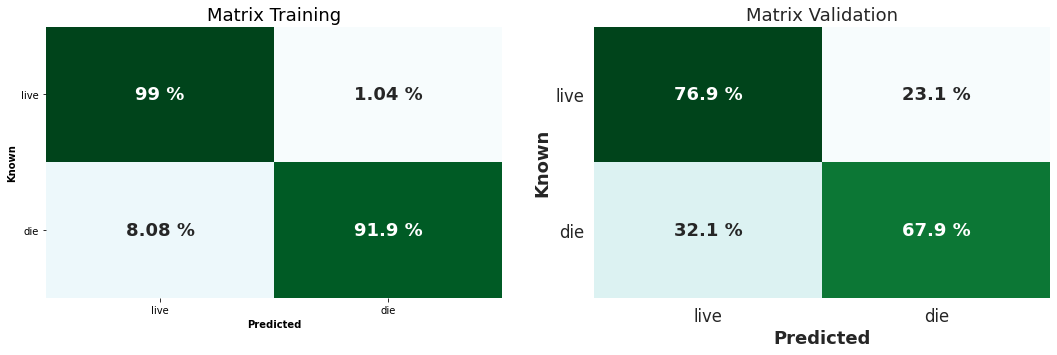

In [24]:
my_functions.plot_confusion_matrices(input_file)

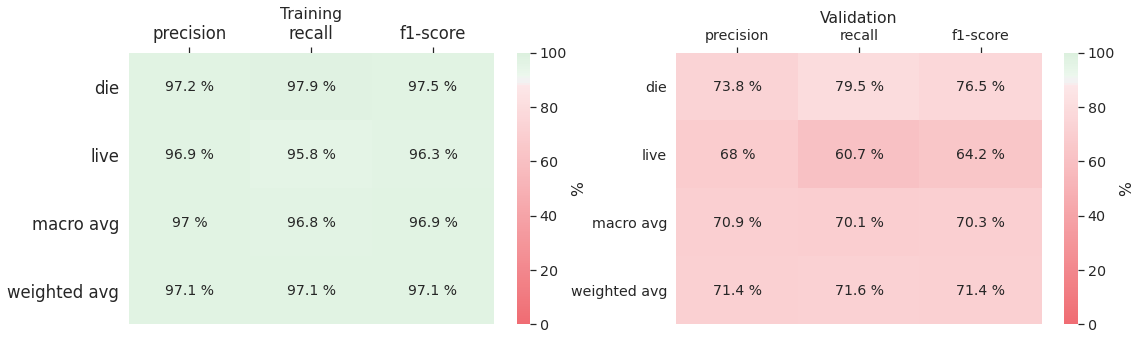

In [11]:
my_functions.plot_classification_reports(input_file)